In [ ]:
!pip install opencv-python

In [2]:
import os
from __future__ import absolute_import,division,print_function,unicode_literals
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath=r"C:\Users\ajarun\data\train"
testpath=r"C:\Users\ajarun\data\test"
labels = {'cats': 0, 'dogs': 1}
fc_size=32 
num_steps=300 
tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
%matplotlib inline

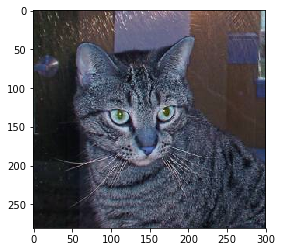

In [5]:
imgloc = r"C:\Users\ajarun\data\train\cats\1.jpg"
img=cv2.imread(imgloc)g)
plt.show()

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


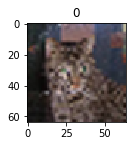

In [6]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

In [7]:
X_train

array([[[[ 44,  40,  36],
         [ 44,  46,  42],
         [ 46,  47,  38],
         ...,
         [106,  80,  73],
         [119,  93,  86],
         [158, 178, 179]],

        [[ 44,  41,  37],
         [ 52,  54,  50],
         [ 45,  46,  37],
         ...,
         [101,  82,  74],
         [113,  94,  86],
         [149, 172, 177]],

        [[ 36,  37,  28],
         [ 47,  47,  38],
         [ 43,  45,  35],
         ...,
         [106,  85,  84],
         [ 95,  83,  79],
         [143, 164, 170]],

        ...,

        [[ 17,  17,  17],
         [ 14,  14,  14],
         [ 15,  15,  15],
         ...,
         [ 70,  77,  92],
         [ 56,  66,  80],
         [  9,  13,  28]],

        [[ 24,  24,  24],
         [ 25,  25,  25],
         [ 26,  26,  26],
         ...,
         [ 50,  58,  67],
         [ 68,  77,  86],
         [ 76,  81,  96]],

        [[ 18,  17,  19],
         [ 20,  19,  21],
         [ 23,  25,  26],
         ...,
         [ 37,  44,  61],
        

In [8]:
def cnn_model_fn(features, labels, mode):

    # Input layer 
    input_layer = tf.reshape(features["x"], [-1, img_size, img_size, num_channels])
    # Convolution layer 1
    conv_layer_1 = tf.layers.conv2d( inputs= input_layer, filters = 32, kernel_size = [ 5, 5 ], padding ="same", activation = tf.nn.relu)
    
    # Pooling layer 1 
    pool_layer_1 = tf.layers.max_pooling2d(inputs=conv_layer_1, pool_size = [ 2, 2 ] ,strides = 2)
    
    # Convolution layer 2 
    
    conv_layer_2 = tf.layers.conv2d( inputs= pool_layer_1, filters = 64, kernel_size = [ 5, 5 ], padding ="same", activation = tf.nn.relu)
    
    # Pooling Layer 2 
    
    pool_layer_2 = tf.layers.max_pooling2d(inputs = conv_layer_2, pool_size = [2,2], strides = 2)
    # Flatten the pooling layer  to pass it to the dense layer 
    pool_layer_2_flat = tf.reshape(pool_layer_2, [ -1, 8 * 8 * 64 ])
    # Fully connected layer
    dense = tf.layers.dense(inputs= pool_layer_2_flat, units = fc_size, activation = tf.nn.relu)
    # Droput layer with drouput probablity 0.4
    dropout = tf.layers.dropout(inputs=dense, rate= 0.4 , training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units = 2 )
    # Configure the predict mode 
    predictions = {
        "classes": tf.argmax(input= logits, axis = 1 ),
        "probabilities": tf.nn.softmax(logits, name = "softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    # Calculate loss for both train and Eval modes
    onehot_labels = tf.one_hot(indices = tf.cast(labels, tf.int32), depth = 2 )
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits = logits)
    # Configue operations for training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op= train_op)
    
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode= mode , loss = loss , eval_metric_ops = eval_metric_ops)

In [9]:

X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=r"C:\Users\ajarun\pets_convnet_model")
                                         #/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_task_type': 'worker', '_num_ps_replicas': 0, '_session_config': None, '_master': '', '_evaluation_master': '', '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022089446A90>, '_service': None, '_save_checkpoints_steps': None, '_device_fn': None, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_train_distribute': None, '_is_chief': True, '_model_dir': 'C:\\Users\\ajarun\\pets_convnet_model', '_num_worker_replicas': 1, '_task_id': 0, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_tf_random_seed': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\aja